## BYOL for image segmentation

Example with UNet model from [segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch/tree/master).

In [1]:
import sys

sys.path.append("./../")

from byol.models import BYOL, UNETModule
from byol.utils import BYOLTransforms1, BYOLTransforms
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

/home/rafael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.oxford_pet import SimpleOxfordPetDataset, BYOLOxfordPetDataset
import os
from torch.utils.data import DataLoader

root = "."
SimpleOxfordPetDataset.download(root)
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 3669


### Training an UNET model on the SimpleOxfordPet Dataset

In [3]:
unet_module = UNETModule()

unet_trainer = pl.Trainer(
    max_epochs=2,
    accelerator=accelerator,
    devices=1,
)

unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-03-02 16:47:37.027413: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 16:47:37.070401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 16:47:37.737540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------

Epoch 0: 100%|██████████| 207/207 [01:36<00:00,  2.16it/s, v_num=46, val_iou=0.669]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 207/207 [01:36<00:00,  2.15it/s, v_num=46, val_iou=0.669]


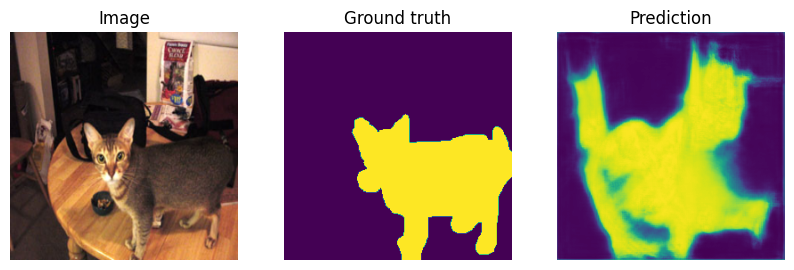

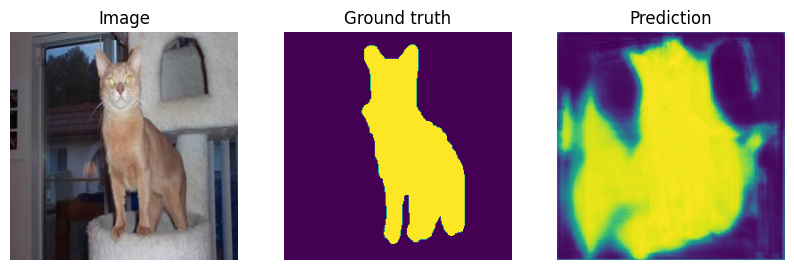

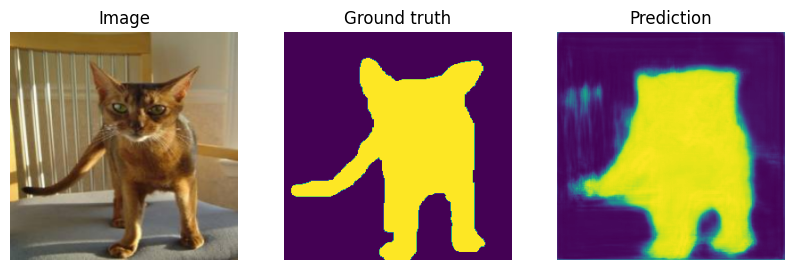

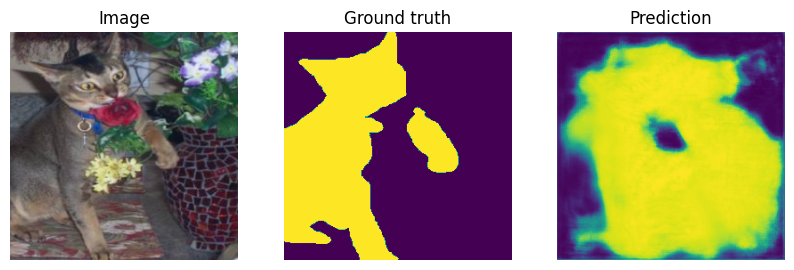

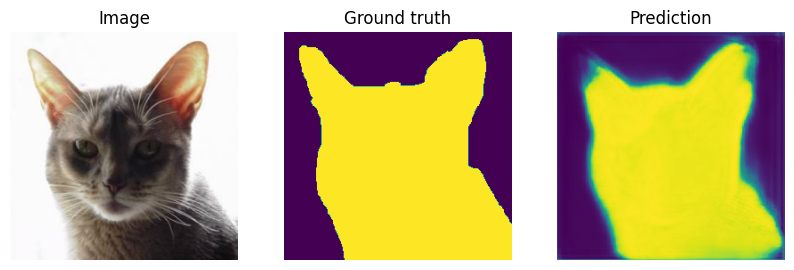

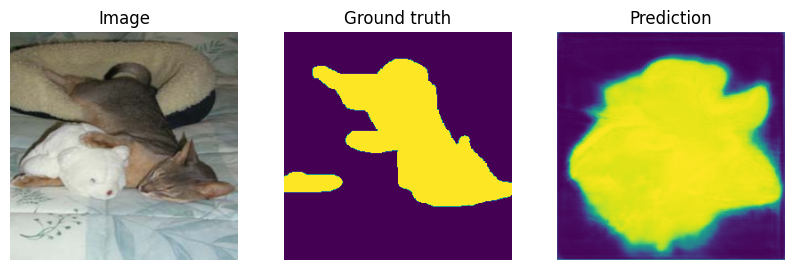

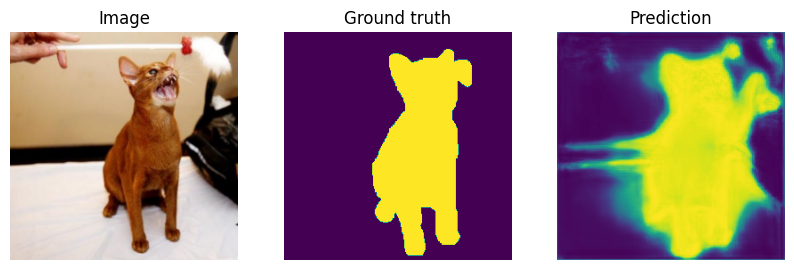

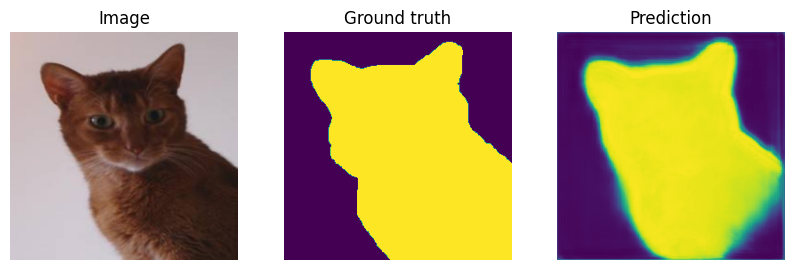

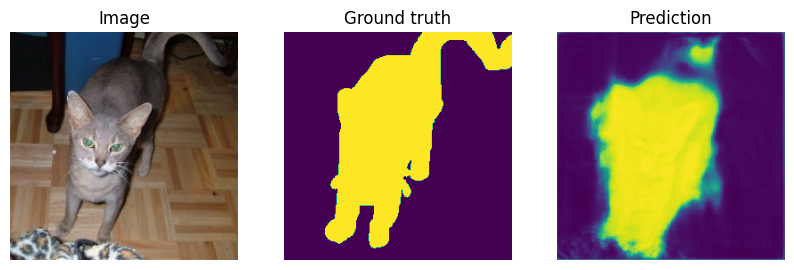

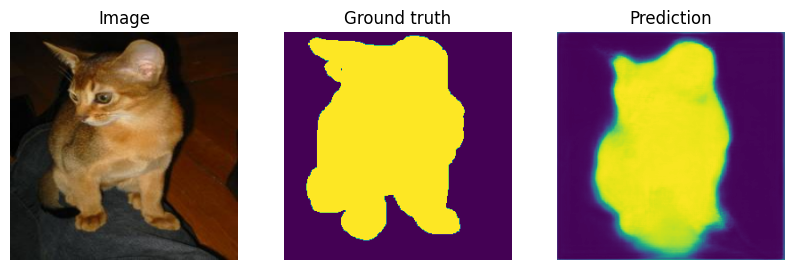

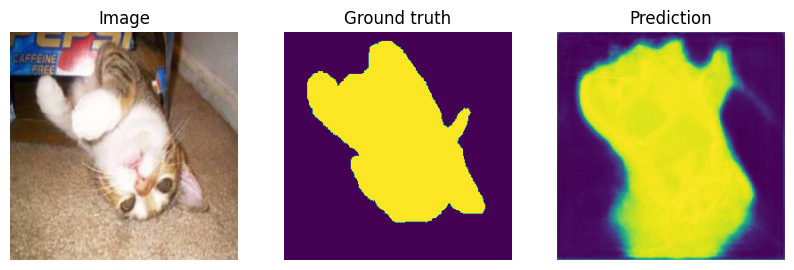

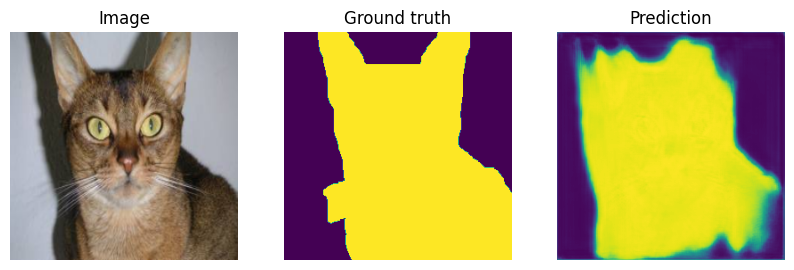

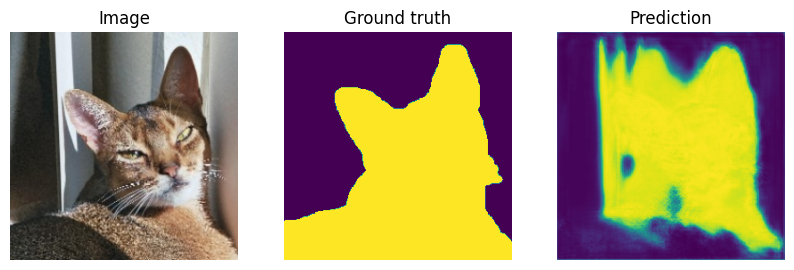

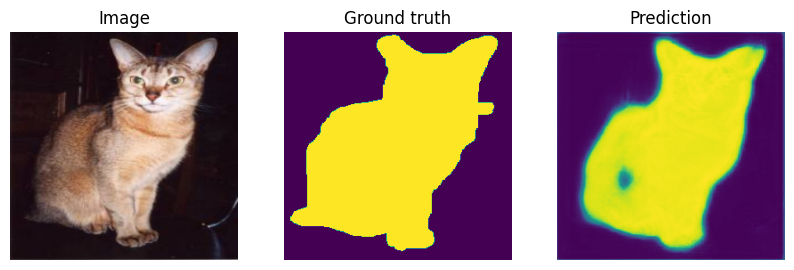

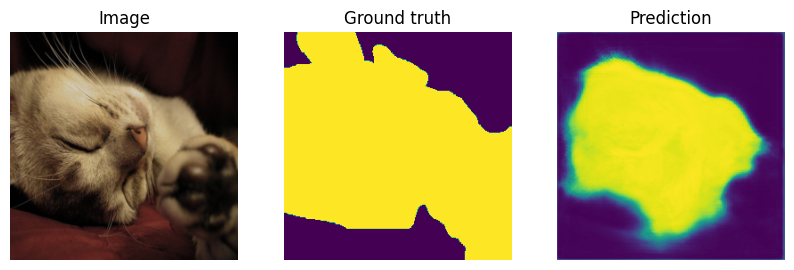

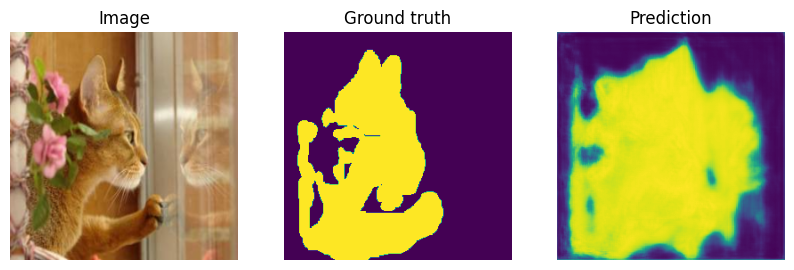

In [4]:
import matplotlib.pyplot as plt

batch = next(iter(test_dataloader))
with torch.no_grad():
    unet_module.eval()
    logits = unet_module(batch["image"].float())
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
     

### Training BYOL on SimpleOxfordPet Dataset

In [5]:
transform = BYOLTransforms(
    view1=BYOLTransforms1(input_size=256),
    view2=BYOLTransforms1(input_size=256)
)
byol_dataset = BYOLOxfordPetDataset(root, "test", transform=transform)

byol_dataloader = DataLoader(byol_dataset, batch_size=64, shuffle=True, num_workers=n_cpu)
byol_module = BYOL(
    hparams={
        "input_dim": 512,
        "hidden_dim": 1024,
        "projection_dim": 256,
        "max_epochs": 10, # used for the cosine scheduler
    },
    model=unet_module.model.encoder,
    batch_type="dict",
)


In [6]:
byol_trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
)

byol_trainer.fit(model=byol_module, train_dataloaders=byol_dataloader) # our model never sees labeled data!

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type               | Params
--------------------------------------------------------------
0 | backbone               | Sequential         | 11.2 M
1 | target_backbone        | Sequential         | 11.2 M
2 | projection_head        | BYOLProjectionHead | 788 K 
3 | prediction_head        | BYOLPredictionHead | 526 K 
4 | target_projection_head | BYOLProjectionHead | 788 K 
5 | loss                   | CosineSimilarity   | 0     
--------------------------------------------------------------
1.3 M     Trainable params
12.0 M    Non-trainable params
13.3 M    Total params
53.122    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/58 [00:00<?, ?it/s] torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:   2%|▏         | 1/58 [00:03<03:42,  0.26it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:   3%|▎         | 2/58 [00:04<01:54,  0.49it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:   5%|▌         | 3/58 [00:04<01:30,  0.61it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:   7%|▋         | 4/58 [00:05<01:17,  0.69it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:   9%|▊         | 5/58 [00:06<01:09,  0.76it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:  10%|█         | 6/58 [00:07<01:04,  0.81it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:  12%|█▏        | 7/58 [00:08<01:00,  0.85it/s, v_num=47]torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
Epoch 0:  14%|█▍ 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 58/58 [00:50<00:00,  1.14it/s, v_num=47, train_loss=-.596]


### Fine-tuning our BYOL-boosted-UNET on the rest of the dataset.

In [7]:
unet_byol_module = UNETModule.from_byol(byol_module)

unet_byol_trainer = pl.Trainer(
    max_epochs=2,
    accelerator=accelerator,
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
unet_byol_trainer.fit(unet_byol_module, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | Unet            | 14.3 M
1 | loss_fn        | DiceLoss        | 0     
2 | validation_iou | SegmentationIOU | 0     
3 | training_iou   | SegmentationIOU | 0     
4 | test_iou       | SegmentationIOU | 0     
---------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 207/207 [01:36<00:00,  2.15it/s, v_num=48, val_iou=0.691]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 207/207 [01:36<00:00,  2.15it/s, v_num=48, val_iou=0.691]


In [19]:
import matplotlib.pyplot as plt

batch = next(iter(test_dataloader))
with torch.no_grad():
    unet_module.eval()
    logits = unet_module(batch["image"].float())

with torch.no_grad():
    unet_byol_module.eval()
    logits_byol = unet_byol_module(batch["image"].float())

pr_masks_unet = logits.sigmoid()
pr_masks_byol = logits_byol.sigmoid()

for image, gt_mask, pr_mask_unet, pr_mask_byol in zip(batch["image"], batch["mask"], pr_masks, pr_masks_byol):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pr_mask_unet.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("UNET Prediction")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(pr_mask_byol.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("BYOL-UNET Prediction")
    plt.axis("off")

    plt.show()
     

TypeError: 'dict' object is not an iterator

In [15]:
unet_trainer.test(unet_module, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 230/230 [00:31<00:00,  7.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.08237095177173615    │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.08237095177173615}]

In [20]:
unet_trainer.test(unet_byol_module, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 230/230 [00:31<00:00,  7.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.7028063535690308     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.7028063535690308}]

In [12]:
# import torch.nn as nn

# unet_module = UNETModule(encoder_name="resnet50")
# m = nn.Sequential(*list(unet_module.model.encoder.children()), nn.AdaptiveAvgPool2d((1, 1)))
# m.eval()
# x = torch.rand(1, 3, 32, 32)
# m(x).flatten(start_dim=1).shape

In [13]:
# import torchvision.models as models

# resnet = models.resnet18(pretrained=False, num_classes=10)
# m = nn.Sequential(*list(resnet.children())[:-1])
# m.eval()
# x = torch.rand(1, 3, 256, 256)
# m(x).flatten(start_dim=1).shape